[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/example_notebooks/uncertainty_estimation.ipynb)

# Overall Uncertainty Estimation
NeuralProphet allows the modelling of overall prediction intervals. We use the standard pinball loss function in the model to estimate different quantiles specified by the user, without any other distributional assumptions. Here, we demonstrate this feature using the peyton manning dataset.

In [15]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

In [16]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "wp_log_peyton_manning.csv")
df.head(3)

,ds,y
0,2007-12-10,9.5908
1,2007-12-11,8.5196
2,2007-12-12,8.1837


# Basic Functionality
For estimating the 0.1 and 0.9 quantiles, or a prediction/confidence interval (PI) of 0.8, the NeuralProphet object can be created as follows by
specifying the required quantiles (in between (0,1)) in a list. The 0.5 quantile is always modelled by default.
The progression of the PinballLoss values through the training epochs can be seen.

In [17]:
pi = 0.8  # prediction interval
qts = [(1 - pi) / 2, pi + (1 - pi) / 2]  # quantiles based on the prediction interval
qts

[0.09999999999999998, 0.9]

In [18]:
m = NeuralProphet(quantiles=qts)
metrics = m.fit(df, freq="D")

In [19]:
future = m.make_future_dataframe(df, periods=30, n_historic_predictions=100)
forecast = m.predict(df=future)

The forecasts df now has columns designated for the different quantiles of the output yhat1. For the
components, only the 50% quantile is shown in the current state of this feature. The uncertainty bands can
be plotted as below.

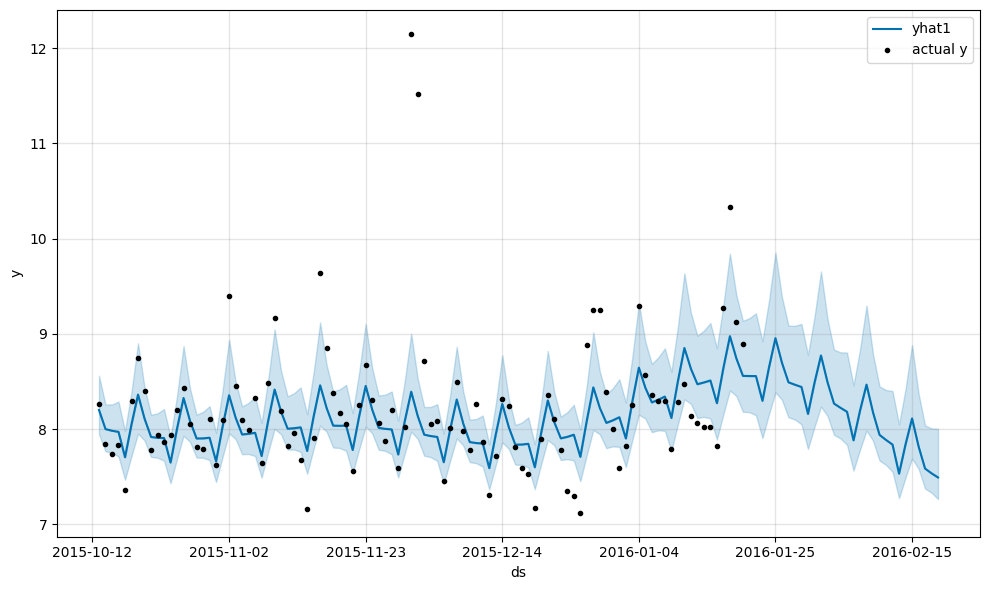

In [20]:
fig_forec = m.plot(forecast)

Similarly the components and parameters can be plotted for the 0.5th quantile. These include a subplot of all
quantiles relative to the 0.5 quantile.

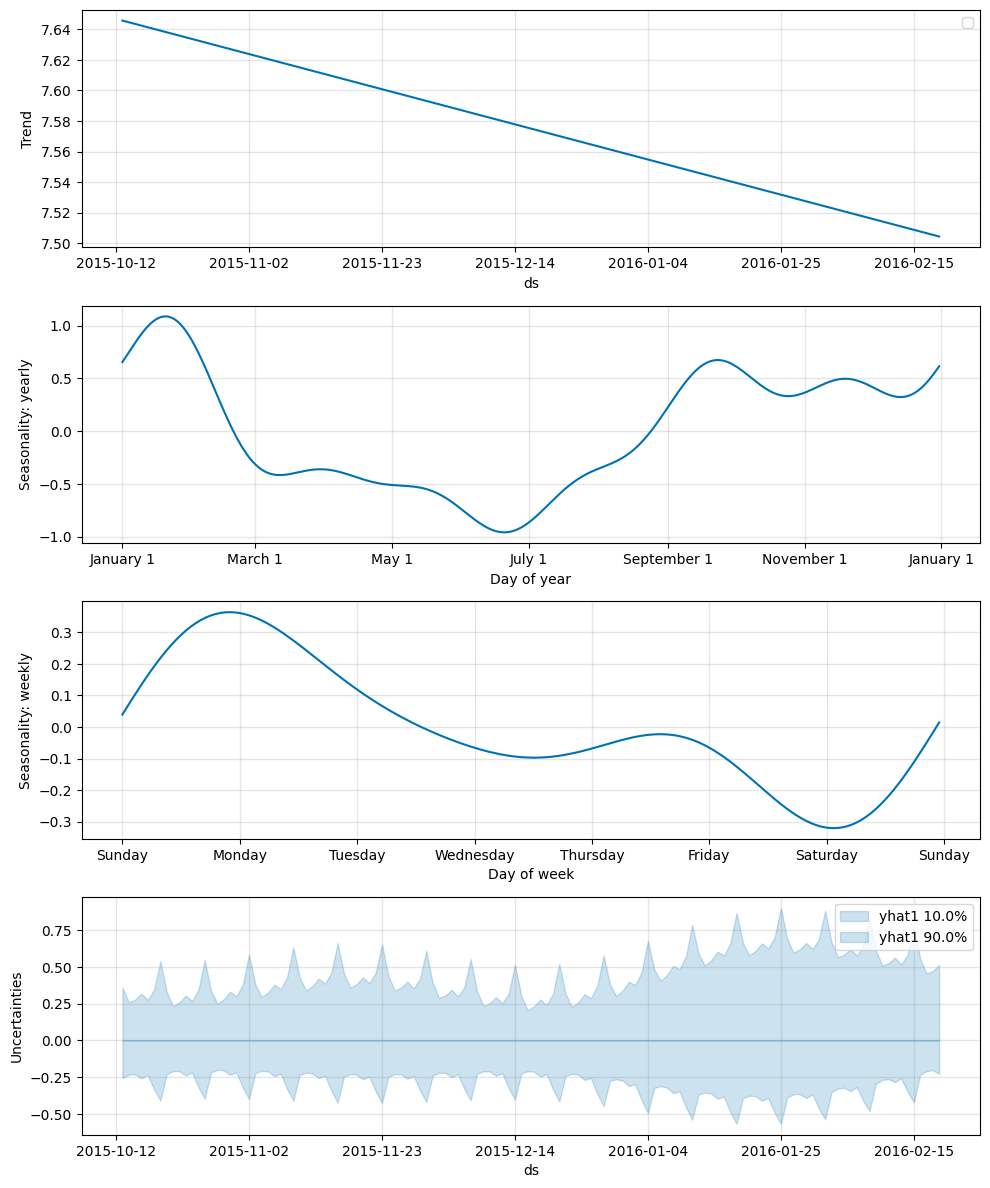

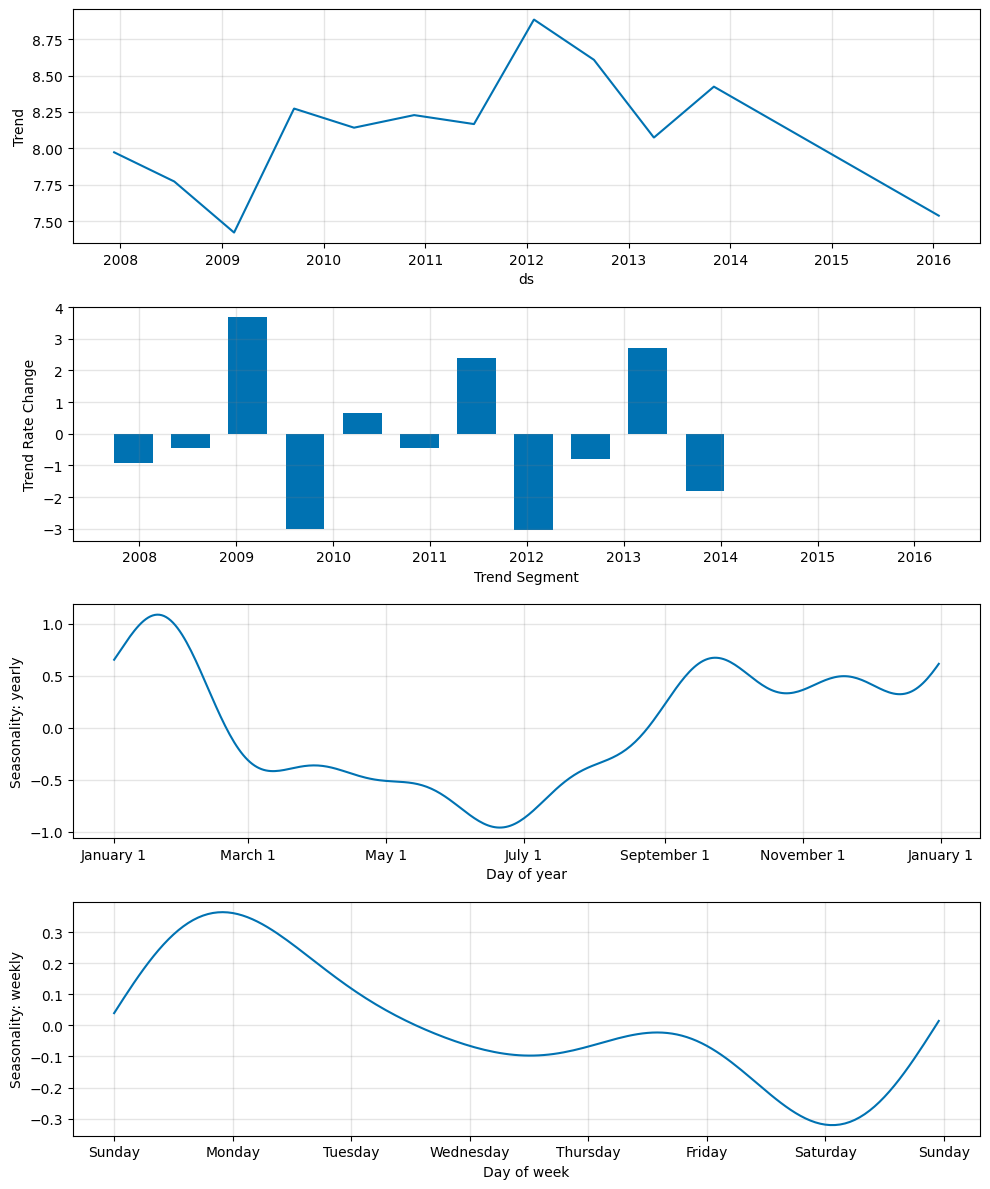

In [21]:
fig_comp = m.plot_components(forecast)
fig_param = m.plot_parameters()

All the other features of the model, such as events, regressors, regularization etc. can be used along with
the quantiles.

In [22]:
playoffs = pd.DataFrame(
    {
        "event": "playoff",
        "ds": pd.to_datetime(
            [
                "2008-01-13",
                "2009-01-03",
                "2010-01-16",
                "2010-01-24",
                "2010-02-07",
                "2011-01-08",
                "2013-01-12",
                "2014-01-12",
                "2014-01-19",
                "2014-02-02",
                "2015-01-11",
                "2016-01-17",
                "2016-01-24",
                "2016-02-07",
            ]
        ),
    }
)

superbowls = pd.DataFrame(
    {
        "event": "superbowl",
        "ds": pd.to_datetime(
            [
                "2010-02-07",
                "2012-02-05",
                "2014-02-02",
                "2016-02-07",
            ]
        ),
    }
)

events_df = pd.concat((playoffs, superbowls))

# NeuralProphet Object
m = NeuralProphet(
    quantiles=qts,
    seasonality_reg=1.5,
)

# set the model to expect these events
m = m.add_events(["playoff", "superbowl"], regularization=0.1)

# create the data df with events
history_df = m.create_df_with_events(df, events_df)
metrics = m.fit(history_df, freq="D")

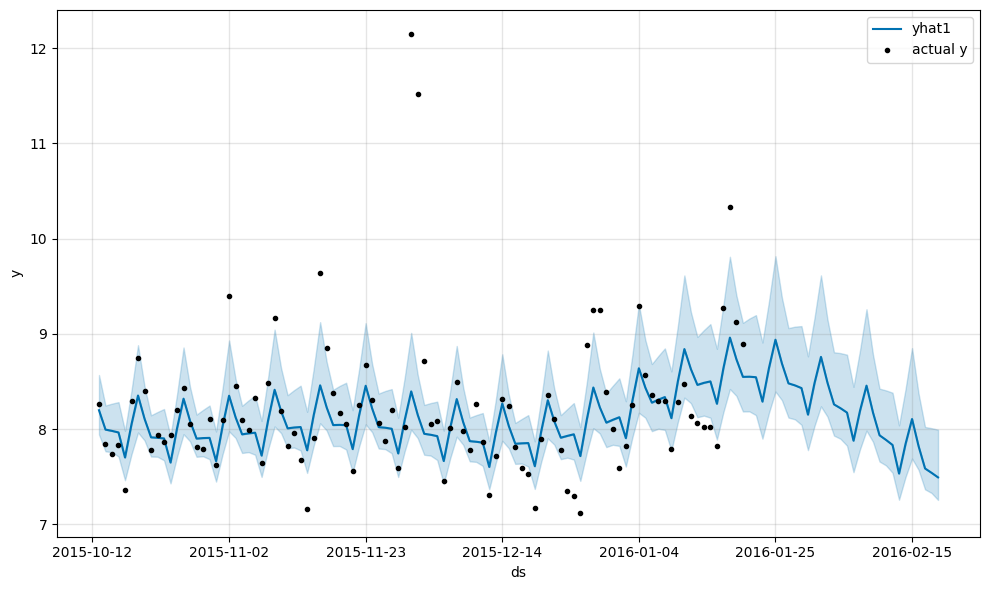

In [23]:
future = m.make_future_dataframe(history_df, events_df, periods=30, n_historic_predictions=100)
forecast = m.predict(df=future)
fig_forec = m.plot(forecast)

## Different Base Loss Functions
In the standard pinball loss, the base error is just the difference between the actuals and the
predicted. However, in NeuralProphet we provide the user, the capability to define other losses for the
base loss such as `MSE`, `MAE` and `Huber`. This can be done as follows.

In [24]:
m = NeuralProphet(
    loss_func="Huber",
    quantiles=qts,
)
metrics = m.fit(df, freq="D")

In [25]:
future = m.make_future_dataframe(df, periods=30, n_historic_predictions=100)
forecast = m.predict(df=future)

## With Auto-Regression
Overall uncertainty can be modelled with the AR-Net as well. The only difference is that,
to plot the forecasts, always a forecast step needs to be specified using the `highlight_nth_step_ahead_of_each_forecast` function. The uncertainty bands are plotted
for that particular forecast step, since otherwise the plot can look quite cluttered.

In [26]:
m = NeuralProphet(
    n_lags=5,
    n_forecasts=3,
    quantiles=qts,
)
metrics = m.fit(df, freq="D")

In [27]:
future = m.make_future_dataframe(df, periods=3, n_historic_predictions=10)
forecast = m.predict(df=future)

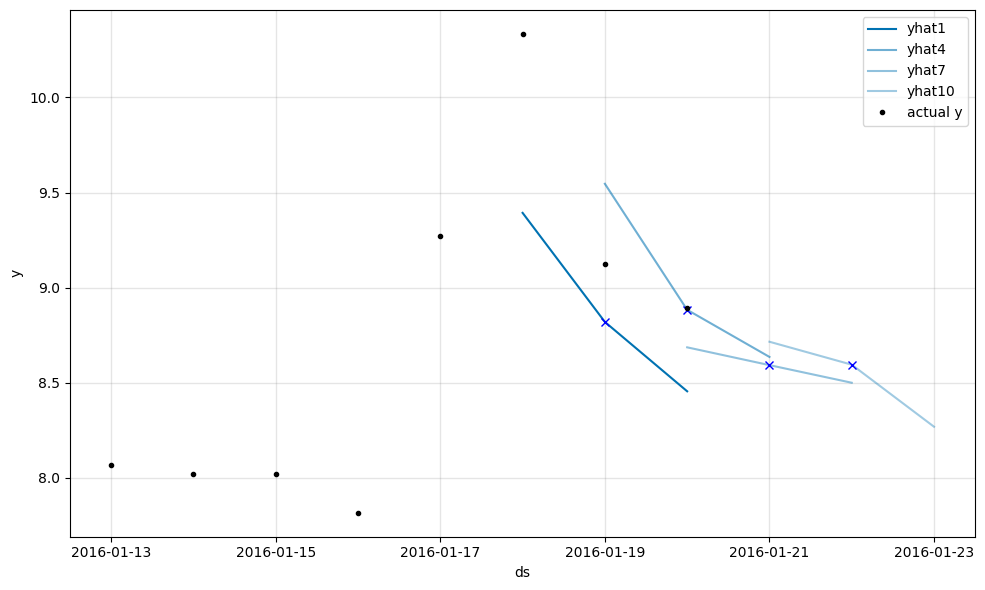

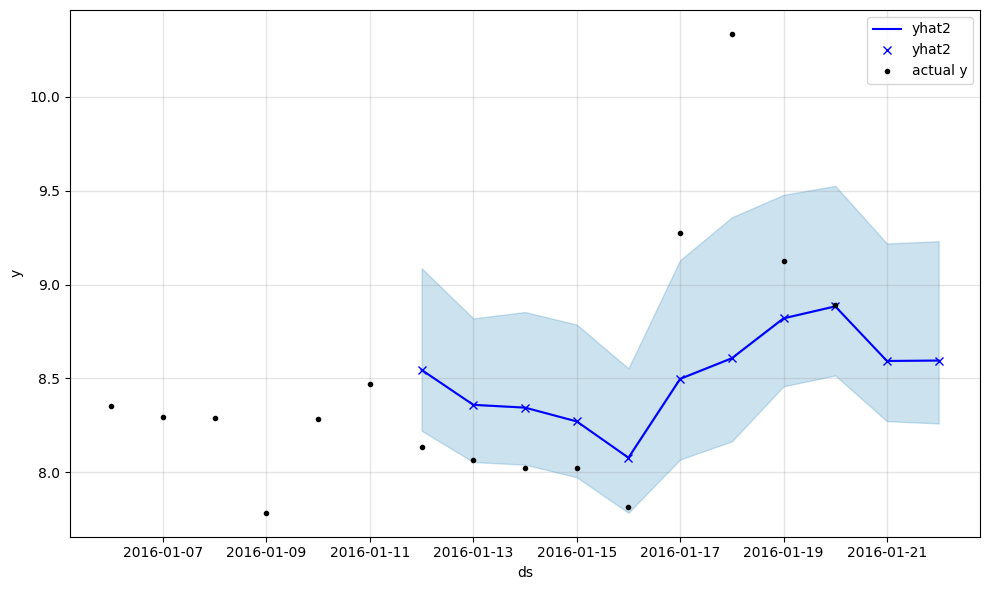

In [28]:
m.highlight_nth_step_ahead_of_each_forecast(2)
fig_last_forec = m.plot_last_forecast(forecast, include_previous_forecasts=3)
fig_forec = m.plot(forecast)